<a href="https://colab.research.google.com/github/SunshineLAData/Kaggle-Project/blob/main/House%20Prices%20-%20Advanced%20Regression%20Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

# import libraries for building linear regression model
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# import library for preparing data
from sklearn.model_selection import train_test_split

# import library for data preprocessing
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sample_submission = pd.read_csv('/content/drive/My Drive/Kaggle - house pricing/sample_submission.csv')
sample_submission.head()


,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [ ]:
test = pd.read_csv('/content/drive/My Drive/Kaggle - house pricing/test.csv')

test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
train = pd.read_csv('/content/drive/My Drive/Kaggle - house pricing/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


I will delete variables that with more than 15% missing data.  Lets take a look of the variables with less than 15% missing data.  For garage related variables, we already have garageCars and GarageArea to cover them, so I will remove them.  For BsmtQual and BsCond, we have SaleCondition and OverallCond to cover them.  All others Basement related and Mas variables do not seem important.  There is one Electrical missing.  Since there is only one, I will delete it as well.  

In [ ]:
#dealing with missing data
train = train.drop((missing_data[missing_data['Total'] > 1]).index,1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)
train.isnull().sum().max() #just checking that there's no missing data missing...

0

In [ ]:
train.Id.nunique()

1459

There are no duplicate ids


Feature Engineering

two_and_two: Properties with two bedrooms and two bathrooms. Why? Through domain expertise, you might know that these properties are popular with investors. This is an indicator variable.
during_recession: The US property market went into recession between 2010 and 2013. Thus being in this time period might influence pricing to a substantial degree.

In [ ]:
# adding total bathroom
train['TotalBath'] = train['BsmtFullBath']	+ 0.5 * train['BsmtHalfBath']	+ train['FullBath']	+ 0.5 * train['HalfBath']	
# adding total square feet
train['TotalSF']=train['1stFlrSF'] + train['2ndFlrSF'] + train['TotalBsmtSF']

In [ ]:
#drop Id
train.drop(columns=['BsmtFullBath', 'BsmtHalfBath','FullBath','HalfBath','1stFlrSF','2ndFlrSF','TotalBsmtSF'], inplace=True)

In [ ]:
train['two_and_two'] = ((train.BedroomAbvGr == 2) & (train.TotalBath == 2)).astype(int)
train['DuringRecession'] = ((train.YrSold >= 2010) & 
                          (train.YrSold <= 2013)).astype(int)
                         

In [ ]:
#get a list of numeric column names
print(train.iloc[:, (np.where((train.dtypes == np.int64) | 
                 (train.dtypes == np.float64)))[0]].columns)


Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'TotalBath', 'TotalSF',
       'two_and_two', 'DuringRecession'],
      dtype='object')


In [ ]:
#Creating a list of numerical columns
num_cols = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'TotalBath', 'TotalSF',
       'two_and_two', 'DuringRecession']


# print summary statistics 
train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1459.0,56.881426,42.310746,20.0,20.0,50.0,70.0,190.0
LotArea,1459.0,10517.363948,9984.666267,1300.0,7549.0,9477.0,11603.0,215245.0
OverallQual,1459.0,6.100069,1.383171,1.0,5.0,6.0,7.0,10.0
OverallCond,1459.0,5.575737,1.113079,1.0,5.0,5.0,6.0,9.0
YearBuilt,1459.0,1971.244003,30.199555,1872.0,1954.0,1973.0,2000.0,2010.0
YearRemodAdd,1459.0,1984.850583,20.644343,1950.0,1967.0,1994.0,2004.0,2010.0
BsmtFinSF1,1459.0,443.943797,456.106417,0.0,0.0,384.0,712.5,5644.0
BsmtFinSF2,1459.0,46.581220,161.369977,0.0,0.0,0.0,0.0,1474.0
BsmtUnfSF,1459.0,567.366004,441.992392,0.0,223.0,479.0,808.0,2336.0
LowQualFinSF,1459.0,5.848526,48.639512,0.0,0.0,0.0,0.0,572.0


Columns with outliers: all Porch related attribures, TotalSF, LoveQualFinSF, MiscVal, GrLivArea, 1stFlrSF, and LotArea

MSSubClass
Skew : 1.41


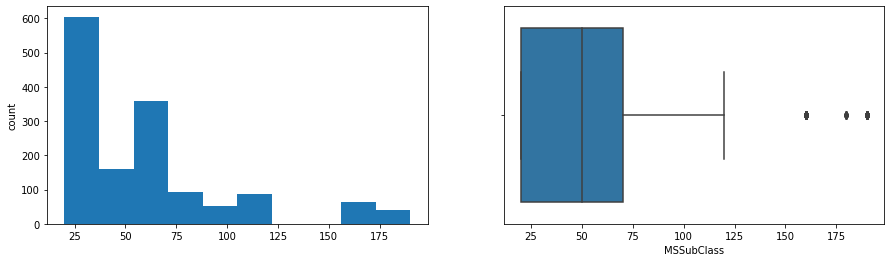

LotArea
Skew : 12.2


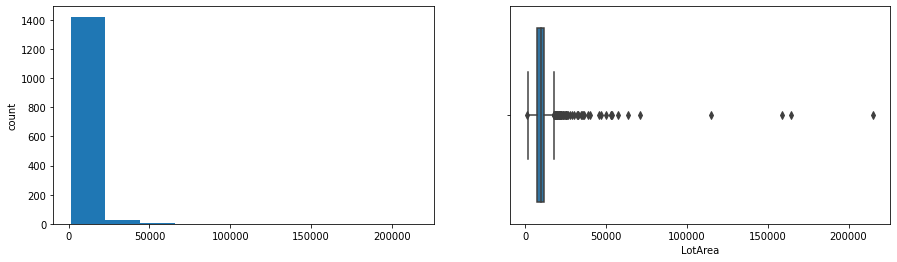

OverallQual
Skew : 0.22


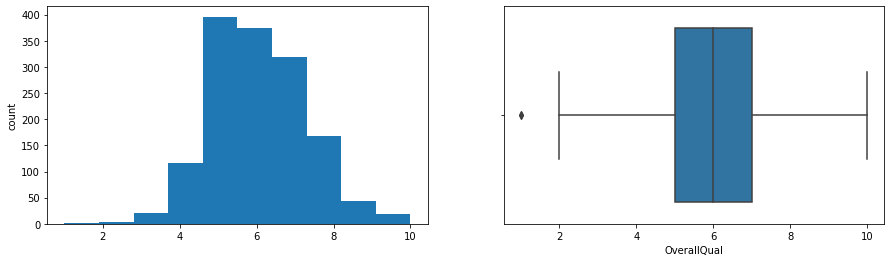

OverallCond
Skew : 0.69


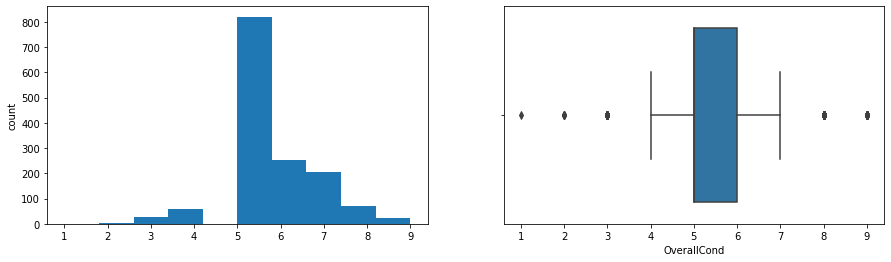

YearBuilt
Skew : -0.61


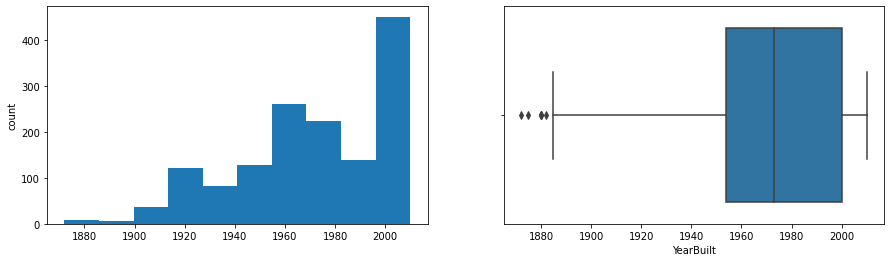

YearRemodAdd
Skew : -0.5


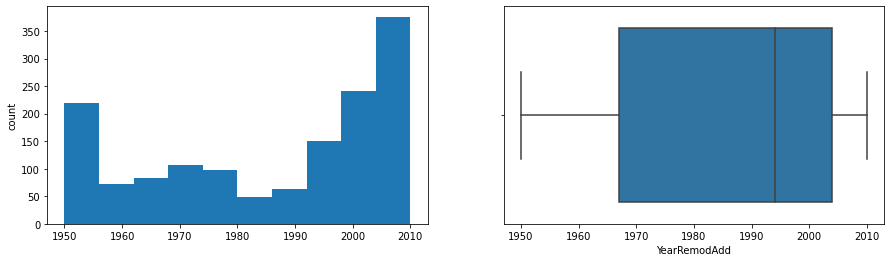

BsmtFinSF1
Skew : 1.69


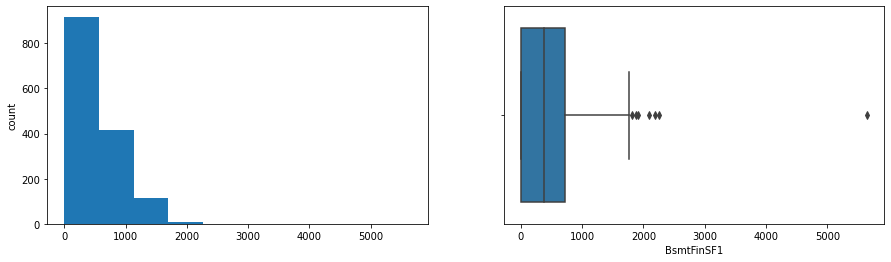

BsmtFinSF2
Skew : 4.25


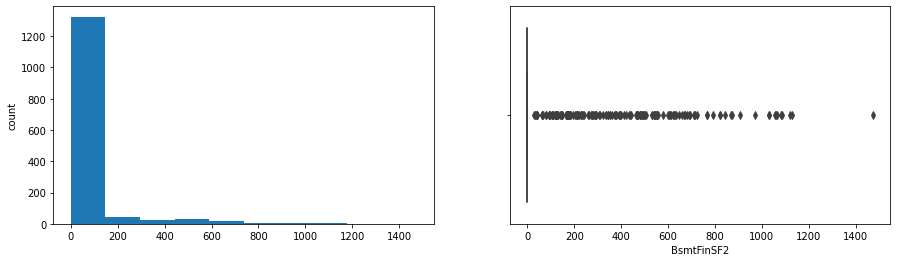

BsmtUnfSF
Skew : 0.92


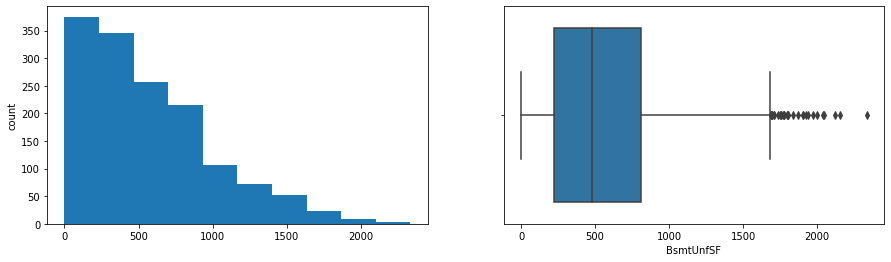

LowQualFinSF
Skew : 9.01


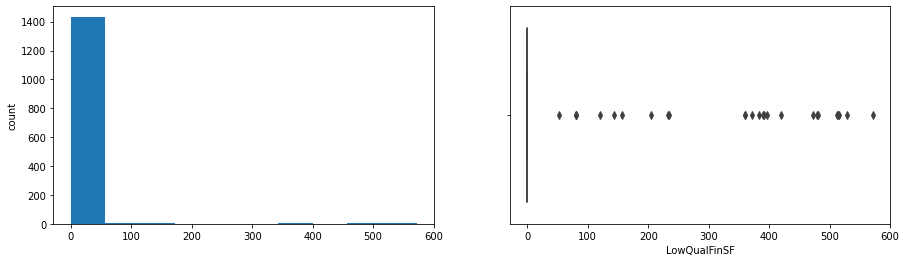

GrLivArea
Skew : 1.37


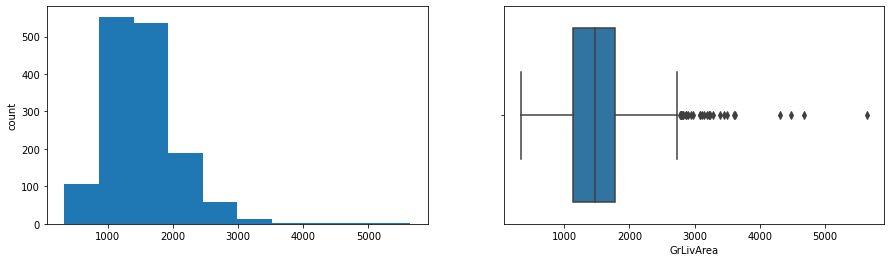

BedroomAbvGr
Skew : 0.21


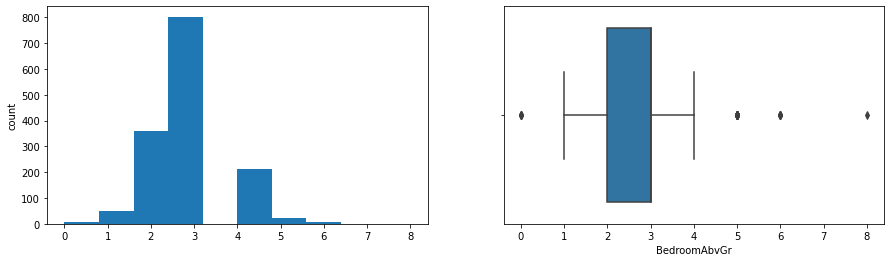

KitchenAbvGr
Skew : 4.49


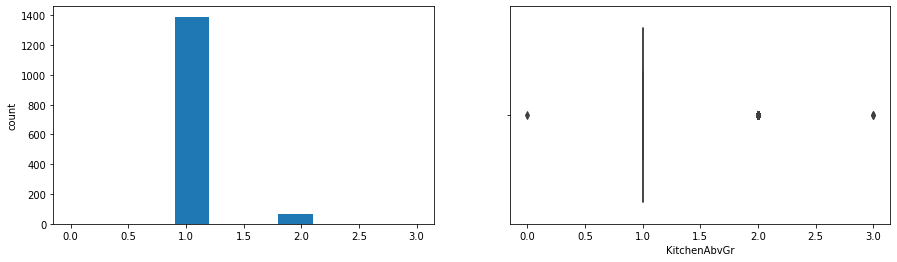

TotRmsAbvGrd
Skew : 0.68


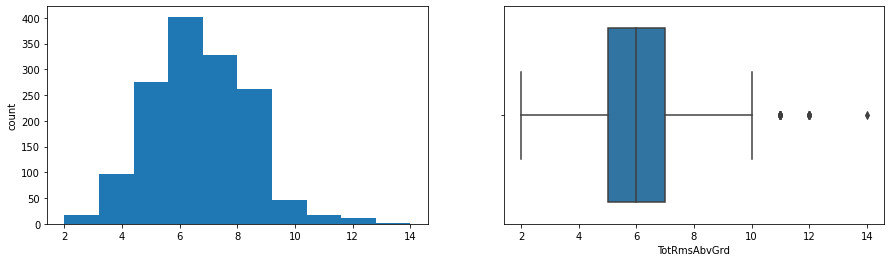

Fireplaces
Skew : 0.65


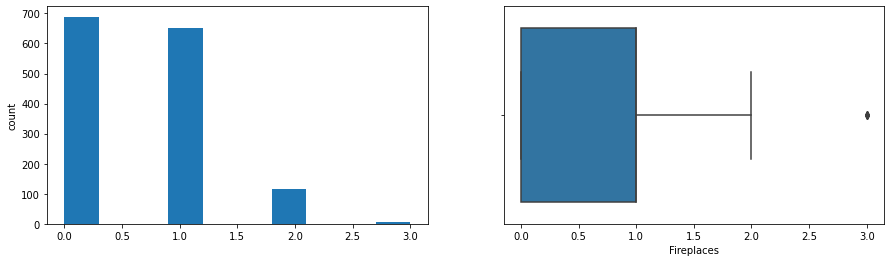

GarageCars
Skew : -0.34


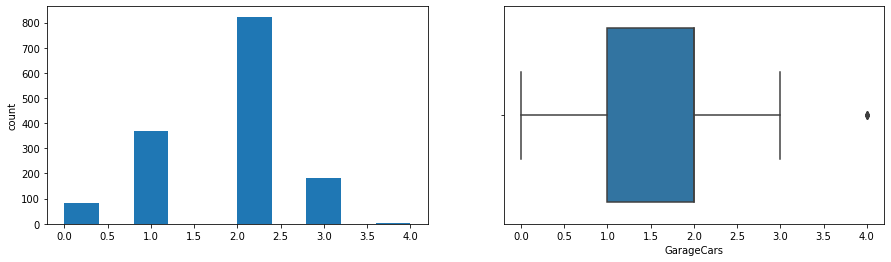

GarageArea
Skew : 0.18


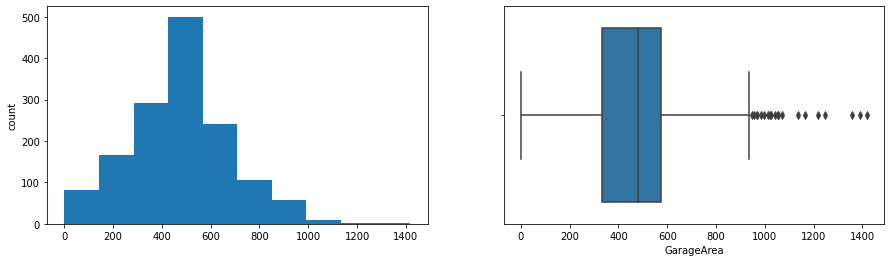

WoodDeckSF
Skew : 1.54


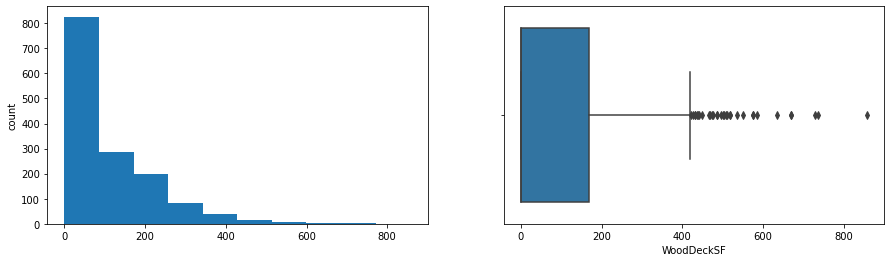

OpenPorchSF
Skew : 2.36


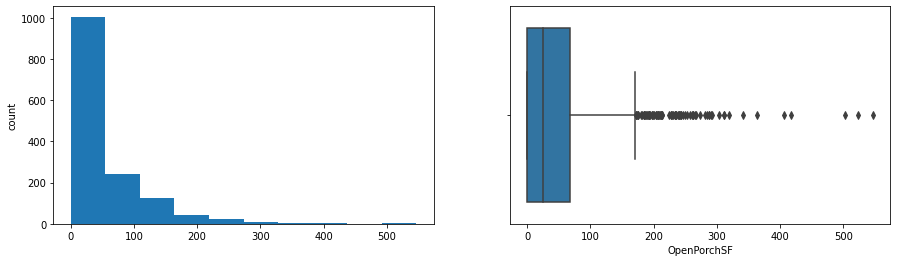

EnclosedPorch
Skew : 3.09


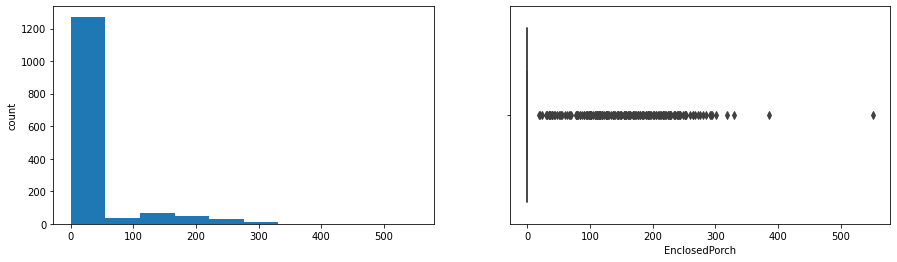

3SsnPorch
Skew : 10.3


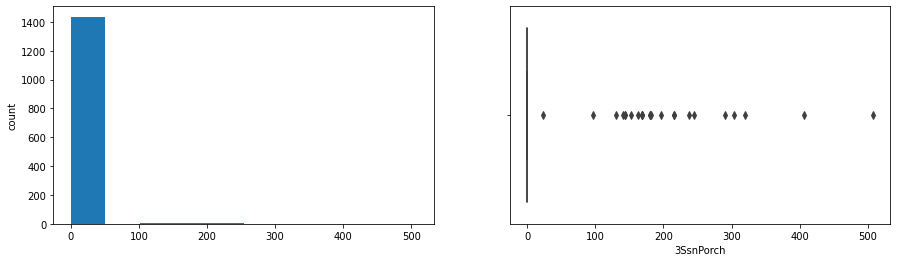

ScreenPorch
Skew : 4.12


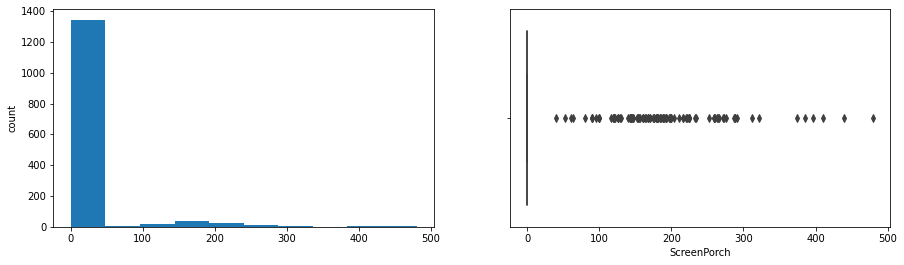

PoolArea
Skew : 14.82


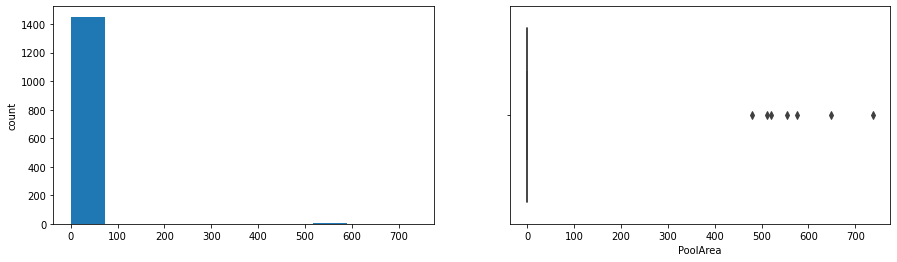

MiscVal
Skew : 24.47


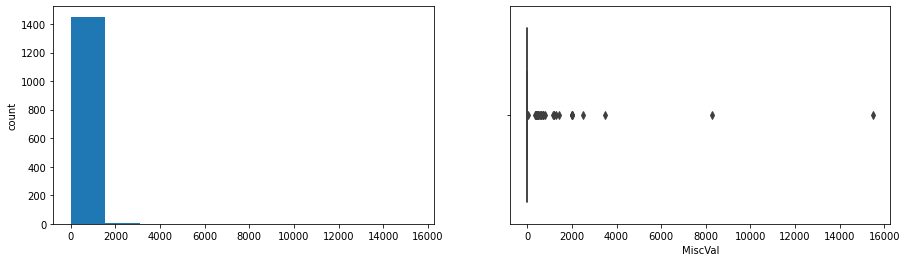

MoSold
Skew : 0.21


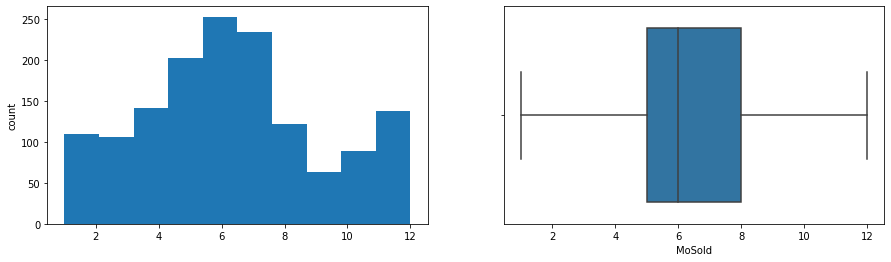

YrSold
Skew : 0.1


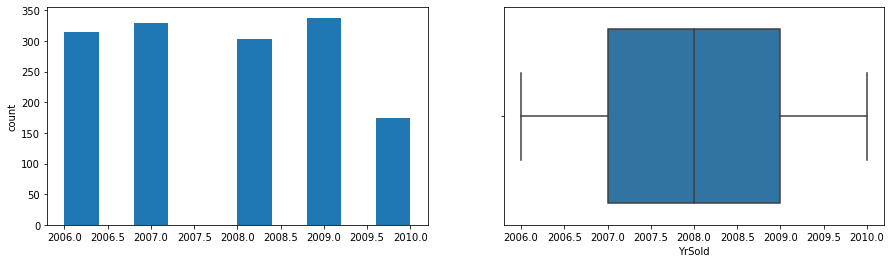

SalePrice
Skew : 1.88


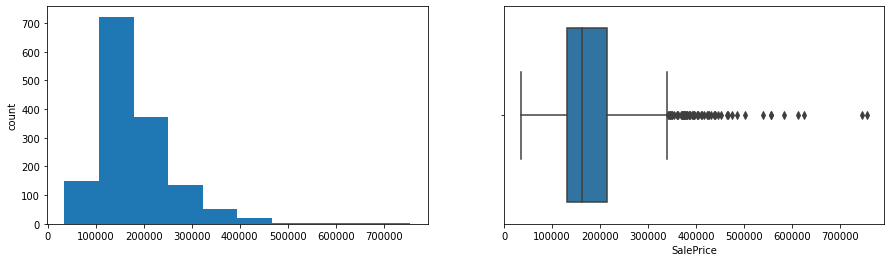

TotalBath
Skew : 0.27


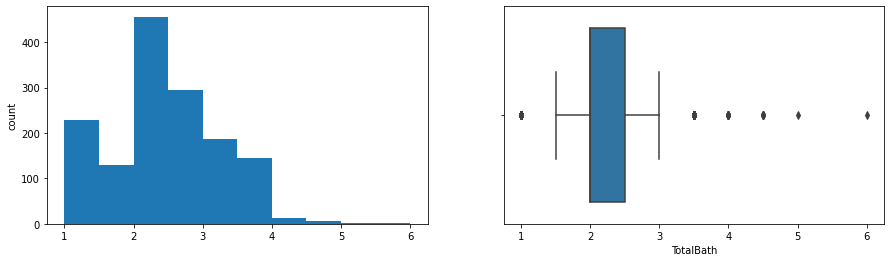

TotalSF
Skew : 1.78


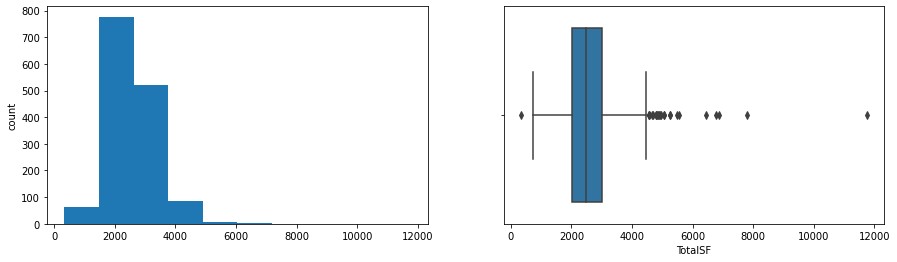

two_and_two
Skew : 2.87


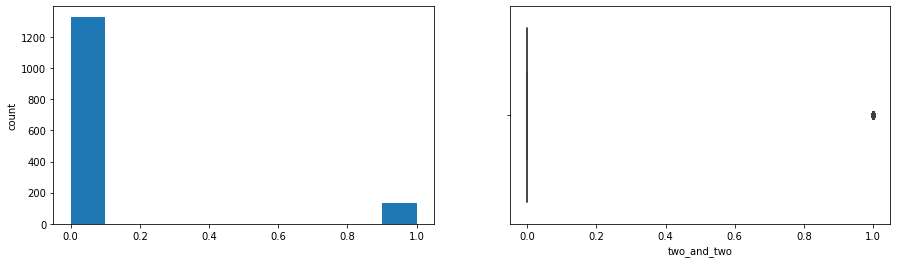

DuringRecession
Skew : 2.34


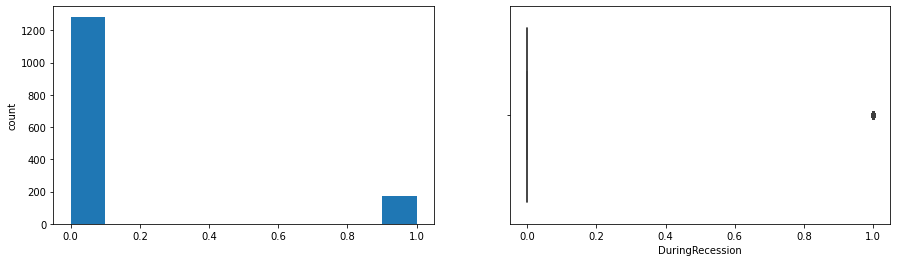

In [ ]:
for col in num_cols:
    print(col)
    print('Skew :',round(train[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    train[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=train[col])
    plt.show()

In [ ]:
#get a list of object column names
print(train.iloc[:, (np.where((train.dtypes == np.object)))[0]].columns)

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


In [ ]:
#Creating list of categorical columns
cat_col= ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

for col in cat_col:
    print(train[col].value_counts(normalize=True)) 
    print('*'*40)  

20     0.367375
60     0.204935
50     0.098698
120    0.059630
30     0.047293
160    0.043180
70     0.041124
80     0.039068
90     0.035641
190    0.020562
85     0.013708
75     0.010966
45     0.008225
180    0.006854
40     0.002742
Name: MSSubClass, dtype: float64
****************************************
RL         0.788211
RM         0.149417
FV         0.044551
RH         0.010966
C (all)    0.006854
Name: MSZoning, dtype: float64
****************************************
Pave    0.995888
Grvl    0.004112
Name: Street, dtype: float64
****************************************
Reg    0.633310
IR1    0.331734
IR2    0.028101
IR3    0.006854
Name: LotShape, dtype: float64
****************************************
Lvl    0.897875
Bnk    0.043180
HLS    0.034270
Low    0.024674
Name: LandContour, dtype: float64
****************************************
AllPub    0.999315
NoSeWa    0.000685
Name: Utilities, dtype: float64
****************************************
Inside     0.720356
Corn

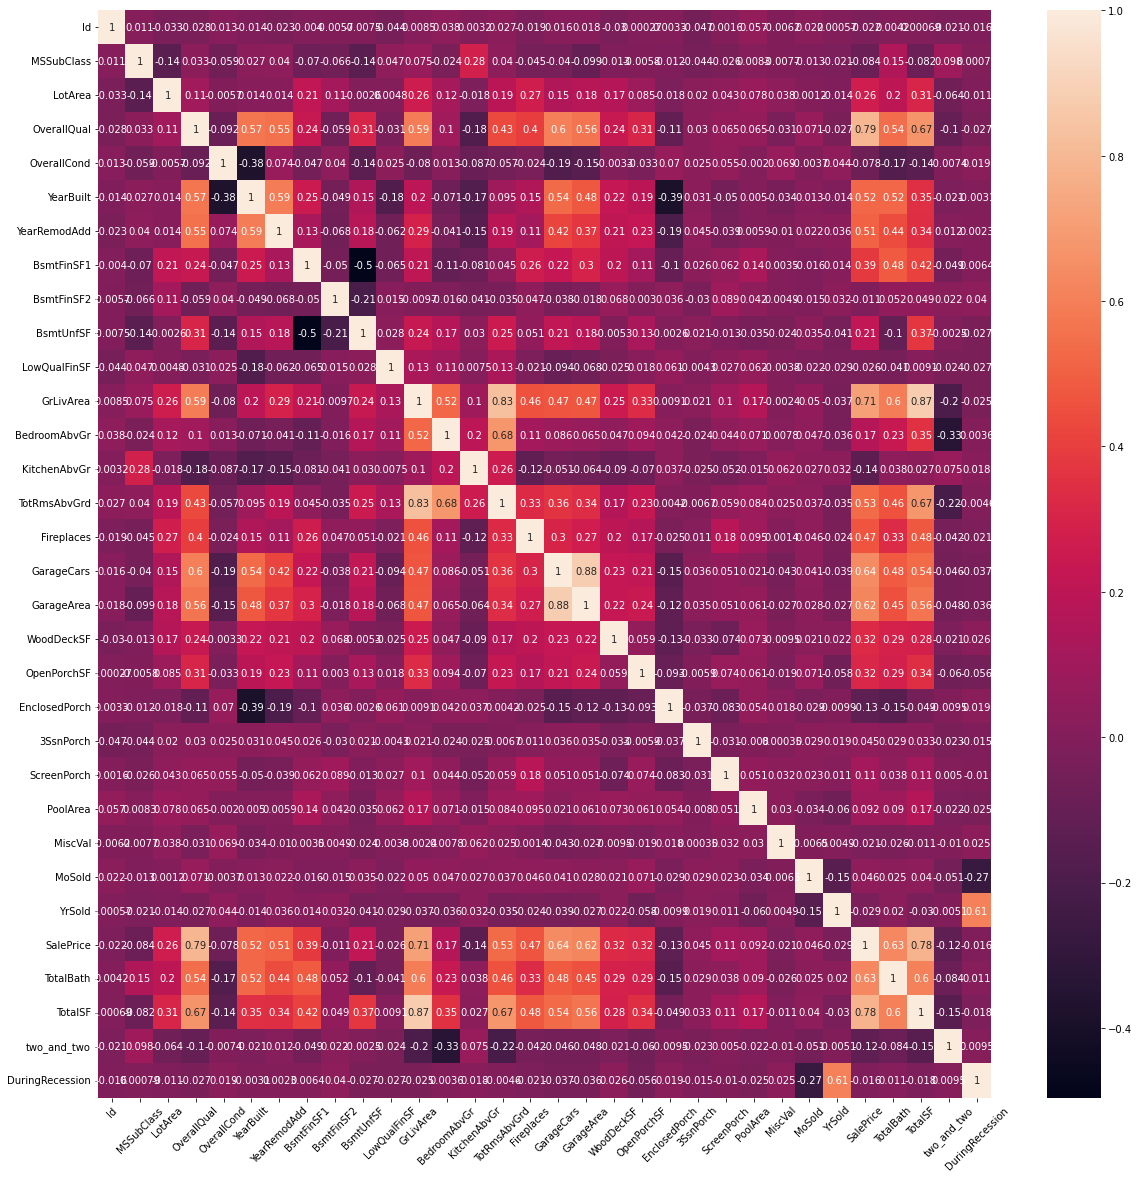

In [ ]:
fig= plt.figure(figsize=(20, 20))
sns.heatmap(train.corr(), annot=True);
plt.xticks(rotation=45);

From the heat map, we can see that OverallQual, GrLivArea, GarageCars, GarageAreas, TotalBath, and Totalsf are highly positively related to the sale price, but GrLivArea is highly correlated to Total SF.  I will remove GrLivArea.

Lets take a closer look to these features

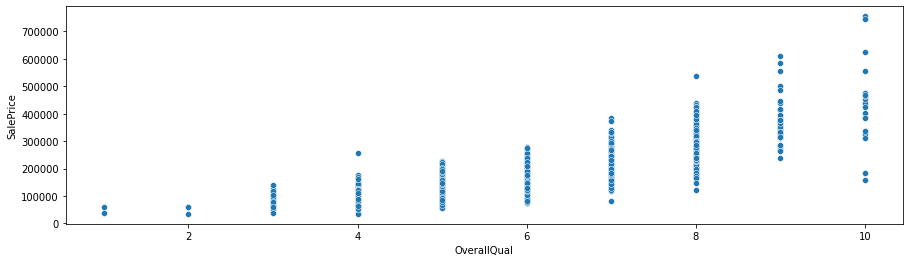

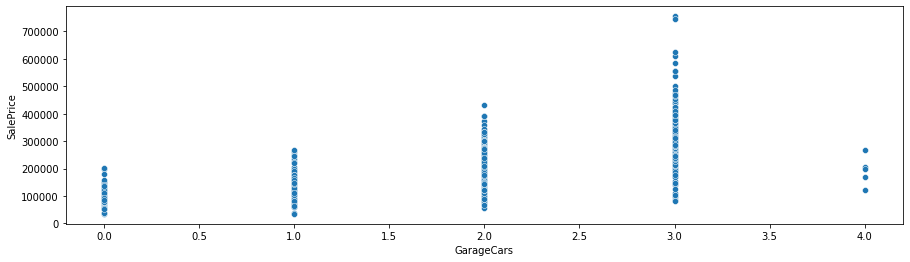

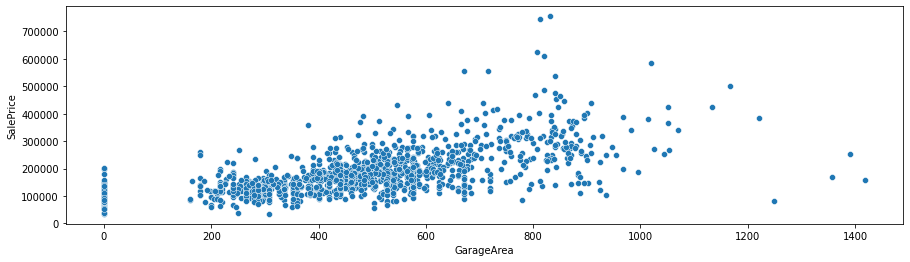

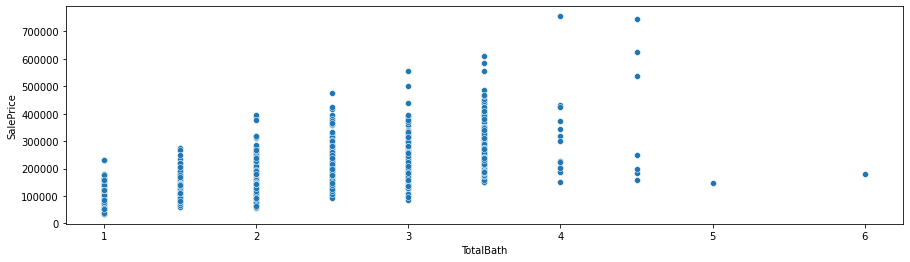

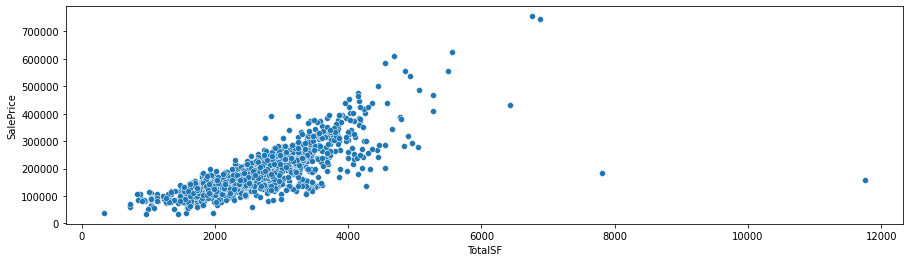

In [ ]:
feature = ['OverallQual',
'GarageCars',
'GarageArea', 
'TotalBath',
'TotalSF']


for col in feature:
    plt.figure(figsize=(15,4))
    sns.scatterplot(data = train, x = col, y = 'SalePrice')


It is interesting that there are properties with hugh areas (total sf, # of garage cars, and # of total bath) with low sale prices.  It could be due to their location.  They could be outliers, but I will keep them there for now.

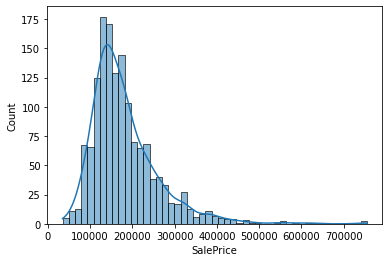

In [ ]:
sns.histplot(data=train, x='SalePrice', kde = True)

In [ ]:
train['SalePrice_log'] = np.log(train['SalePrice'])

As the dependent variable is sightly skewed, we will apply a log transformation on the SalePrice column and check the distribution of the transformed column.

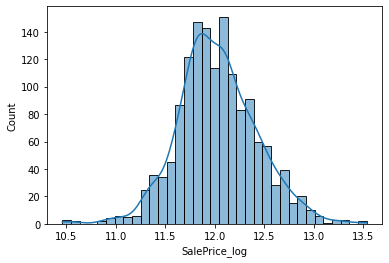

In [ ]:

sns.histplot(data=train, x='SalePrice_log', kde = True)

## **Categorical features**


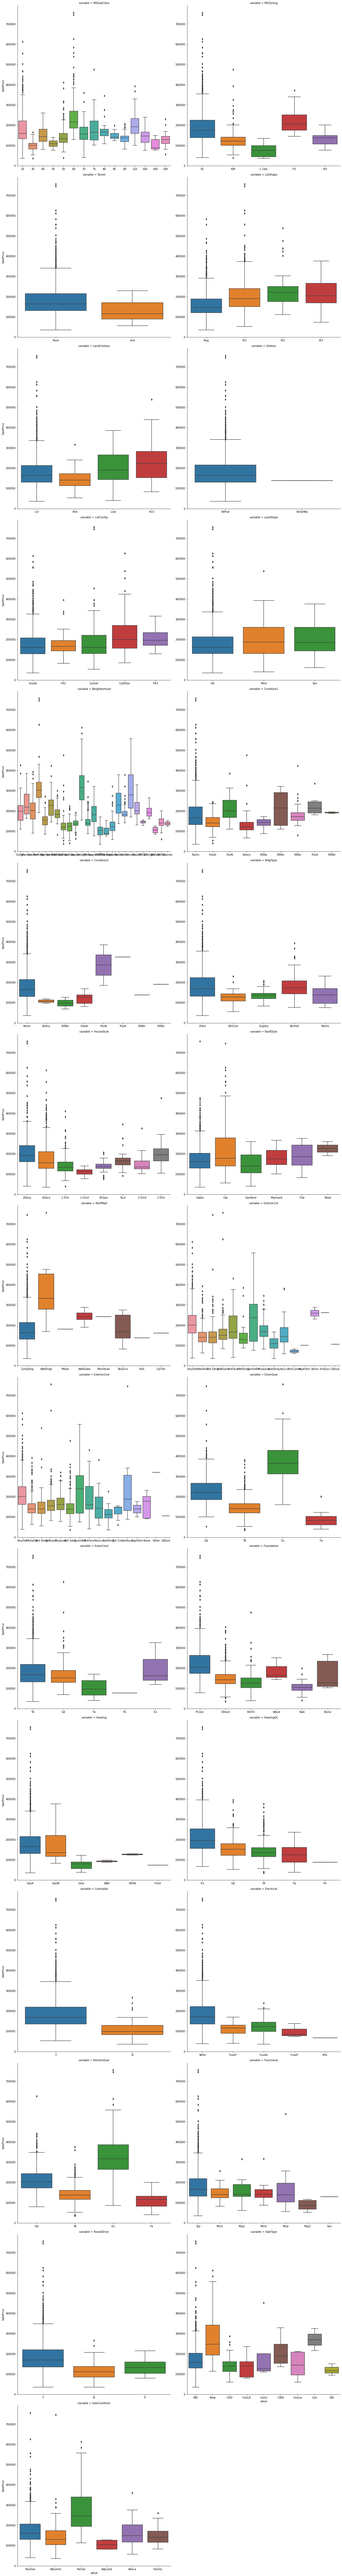

In [ ]:
for c in cat_col:
    train[c] = train[c].astype('object')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    #x=plt.xticks(rotation=180)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=cat_col)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=9)
g = g.map(boxplot, "value", "SalePrice")

In [ ]:
#Creating list of category variables affecting sale price
feature_cat= ['MSZoning', 'Neighborhood', 'ExterQual', 'Heating', 'CentralAir', 'KitchenQual', 'PavedDrive', 'SaleCondition']


In [ ]:
import scipy.stats as stats

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
cat_encoded = []
for q in feature_cat:  
    encode(train, q)
    cat_encoded.append(q+'_E')
print(cat_encoded)

['MSZoning_E', 'Neighborhood_E', 'ExterQual_E', 'Heating_E', 'CentralAir_E', 'KitchenQual_E', 'PavedDrive_E', 'SaleCondition_E']


Using Spearman correlation to see all numeric and categorize features

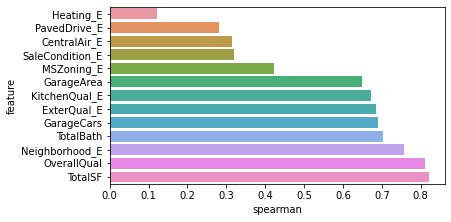

In [ ]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = feature + cat_encoded
spearman(train, features)


GarageCars is similar to GarageArea, and GarageCars is higher correlated to SalePrice.  I am going to drop GarageArea.
Heating, PavedDrive, CentralAir, SaleCondition, and MSZoning do not strongly related to SalePrice.  I will drop them as well.

In [ ]:
#list of final features
final_list = [
'KitchenQual',
'ExterQual',
'Neighborhood',
'OverallQual',
'GarageCars',
'TotalBath',
'TotalSF',
'SalePrice_log']


final_col = train[final_list]


#Select categorical features
rest_object_columns = final_col.select_dtypes(include=['object'])
#Using One hot encoder for objects
train_final = pd.get_dummies(final_col) 
train_final.head()

,OverallQual,GarageCars,TotalBath,TotalSF,SalePrice_log,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,7,2,3.5,2566,12.247694,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,2,2.5,2524,12.109011,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,7,2,3.5,2706,12.317167,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,3,2.0,2473,11.849398,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,3,3.5,3343,12.429216,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## **Run Regressions**

In [ ]:
# separate the dependent and indepedent variable
Y = train_final['SalePrice_log']
X = train_final.drop(columns = {'SalePrice_log'})

# add the intercept term
X = sm.add_constant(X)

# splitting the data in 70:30 ratio of train to test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30 , random_state=1)


In [ ]:
# create the model
#X_train, X_test, y_train, y_test
model1 = sm.OLS(y_train, X_train)#write your code here

model1 = model1.fit()
# get the model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     203.6
Date:                Mon, 27 Sep 2021   Prob (F-statistic):               0.00
Time:                        00:15:19   Log-Likelihood:                 550.72
No. Observations:                1021   AIC:                            -1031.
Df Residuals:                     986   BIC:                            -858.9
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    7.0219      0.027    264.951      0.000       6.970       7.074
OverallQual              0.0830      0.006     13.356      0.000       0.071       0.095
GarageCars               0.0612      0.009      6.927      0.000       0.044       0.079
TotalBath                0.0599      0.008      7.406      0.000       0.044       0.076
TotalSF                  0.0002   9.55e-06     17.668      0.000       0.000       0.000
KitchenQual_Ex           1.8458      0.023     81.438      0.000       1.801       1.890
KitchenQual_Fa           1.6684      0.027     62.265      0.000       1.616       1.721
KitchenQual_Gd           1.7802      0.014    127.253      0.000       1.753       1.808
KitchenQual_TA           1.7275      0.012    139.676      0.000       1.703       1.752
ExterQual_Ex             1.7915      0.031     58.121      0.000       1.731       1.852
ExterQual_Fa             1.6746      0.039     43.144      0.000       1.598       1.751
ExterQual_Gd             1.7722      0.017    103.245      0.000       1.739       1.806
ExterQual_TA             1.7835      0.015    116.585      0.000       1.754       1.814
Neighborhood_Blmngtn     0.2517      0.042      6.017      0.000       0.170       0.334
Neighborhood_Blueste     0.1806      0.098      1.838      0.066      -0.012       0.373
Neighborhood_BrDale      0.0833      0.040      2.090      0.037       0.005       0.161
Neighborhood_BrkSide     0.2297      0.024      9.694      0.000       0.183       0.276
Neighborhood_ClearCr     0.4418      0.030     14.676      0.000       0.383       0.501
Neighborhood_CollgCr     0.3264      0.016     20.409      0.000       0.295       0.358
Neighborhood_Crawfor     0.4424      0.025     17.533      0.000       0.393       0.492
Neighborhood_Edwards     0.2055      0.019     10.976      0.000       0.169       0.242
Neighborhood_Gilbert     0.3437      0.021     16.733      0.000       0.303       0.384
Neighborhood_IDOTRR      0.0677      0.029      2.334      0.020       0.011       0.125
Neighborhood_MeadowV     0.0990      0.040      2.456      0.014       0.020       0.178
Neighborhood_Mitchel     0.2861      0.026     10.898      0.000       0.235       0.338
Neighborhood_NAmes       0.2751      0.014     19.354      0.000       0.247       0.303
Neighborhood_NPkVill     0.2037      0.080      2.533      0.011       0.046       0.361
Neighborhood_NWAmes      0.2967      0.022     13.530      0.000       0.254       0.340
Neighborhood_NoRidge     0.4093      0.030     13.713      0.000       0.351       0.468
Neighborhood_NridgHt     0.3943      0.026     15.298      0.000       0.344       0.445
Neighborhood_OldTown     0.1495      0.018      8.091      0.000       0.113       0.186
Neighborhood_SWISU       0.2362      0.034      6.984    

VIF values are all below 5 

# Train the XGBoost Model

In [ ]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train, verbose=False)

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

[00:15:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:15:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

,OverallQual,GarageCars,TotalBath,TotalSF,SalePrice_log,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,7,2,3.5,2566,12.247694,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,2,2.5,2524,12.109011,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,7,2,3.5,2706,12.317167,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,3,2.0,2473,11.849398,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,3,3.5,3343,12.429216,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
predictions = my_model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 0.10670431784166286


Mean Absolute error is about 10% which is pretty good.

In [ ]:
#Prepare test data for predictions
# adding total bathroom
test['TotalBath'] = test['BsmtFullBath']	+ 0.5 * test['BsmtHalfBath']	+ test['FullBath']	+ 0.5 * test['HalfBath']	
# adding total square feet
test['TotalSF']=test['1stFlrSF'] + test['2ndFlrSF'] + test['TotalBsmtSF']

#list of final features
final_list = [
'KitchenQual',
'ExterQual',
'Neighborhood',
'OverallQual',
'GarageCars',
'TotalBath',
'TotalSF']


final_col_test = test[final_list]


#Select categorical features
rest_object_columns = final_col_test.select_dtypes(include=['object'])
#Using One hot encoder for objects
test_final = pd.get_dummies(final_col_test) 
test_final.head()

# add the intercept term
test_final = sm.add_constant(X)



In [ ]:
X_test.head()

,const,OverallQual,GarageCars,TotalBath,TotalSF,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
1108,1.0,6,2,2.5,2614,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
111,1.0,7,2,2.5,1814,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1273,1.0,6,1,2.0,2376,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1147,1.0,7,1,1.5,2268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
368,1.0,5,1,1.0,2536,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:

# make predictions
predictions = my_model.predict(test_final)

In [ ]:
#Antilog Sale Price
predictions=np.exp(predictions)

In [ ]:
output = pd.DataFrame({'Id':test['Id'], 'SalePrice':predictions})
output = output.to_csv('submission.csv',index=False)
print('Submission saved successfully')

Submission saved successfully
